# 手写数字识别 CNN (使用 MPS 加速)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

# 检查MPS设备是否可用
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: mps


In [2]:
# 定义CNN模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 第一层卷积: 1个输入通道, 32个输出通道,  kernel_size=3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # 第二层卷积: 32个输入通道, 64个输出通道, kernel_size=3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # 池化层: kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 全连接层: 7*7*64 -> 128
        self.fc1 = nn.Linear(7*7*64, 128)
        # 全连接层: 128 -> 10 (10个类别)
        self.fc2 = nn.Linear(128, 10)
        # Dropout层
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 第一层卷积 + ReLU + 池化
        x = self.pool(F.relu(self.conv1(x)))
        # 第二层卷积 + ReLU + 池化
        x = self.pool(F.relu(self.conv2(x)))
        # 展平
        x = x.view(-1, 7*7*64)
        # 全连接层 + ReLU + Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        # 输出层
        x = self.fc2(x)
        return x

In [3]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 加载MNIST数据集
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

# 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# 初始化模型、损失函数和优化器
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# 训练模型
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 100 == 99:
            print(f'[{epoch}, {batch_idx+1}] loss: {running_loss/100:.3f}')
            running_loss = 0.0

# 测试模型
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

In [6]:
# 开始训练和测试
epochs = 5
start_time = time.time()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    test(model, device, test_loader, criterion)

end_time = time.time()
print(f'训练和测试总用时: {end_time - start_time:.2f}秒')

# 保存模型
torch.save(model.state_dict(), 'model/mnist_cnn_model.pth')
print('模型已保存为 model/mnist_cnn_model.pth')

[1, 100] loss: 0.738
[1, 200] loss: 0.222
[1, 300] loss: 0.169
[1, 400] loss: 0.155
[1, 500] loss: 0.137
[1, 600] loss: 0.106
[1, 700] loss: 0.102
[1, 800] loss: 0.105
[1, 900] loss: 0.093
Test set: Average loss: 0.0006, Accuracy: 9868/10000 (98.68%)
[2, 100] loss: 0.080
[2, 200] loss: 0.068
[2, 300] loss: 0.088
[2, 400] loss: 0.078
[2, 500] loss: 0.079
[2, 600] loss: 0.076
[2, 700] loss: 0.065
[2, 800] loss: 0.071
[2, 900] loss: 0.077
Test set: Average loss: 0.0005, Accuracy: 9896/10000 (98.96%)
[3, 100] loss: 0.064
[3, 200] loss: 0.058
[3, 300] loss: 0.058
[3, 400] loss: 0.058
[3, 500] loss: 0.049
[3, 600] loss: 0.052
[3, 700] loss: 0.057
[3, 800] loss: 0.050
[3, 900] loss: 0.055
Test set: Average loss: 0.0004, Accuracy: 9904/10000 (99.04%)
[4, 100] loss: 0.043
[4, 200] loss: 0.045
[4, 300] loss: 0.029
[4, 400] loss: 0.040
[4, 500] loss: 0.044
[4, 600] loss: 0.050
[4, 700] loss: 0.052
[4, 800] loss: 0.038
[4, 900] loss: 0.045
Test set: Average loss: 0.0004, Accuracy: 9913/10000 (99.1

## 模型预测演示

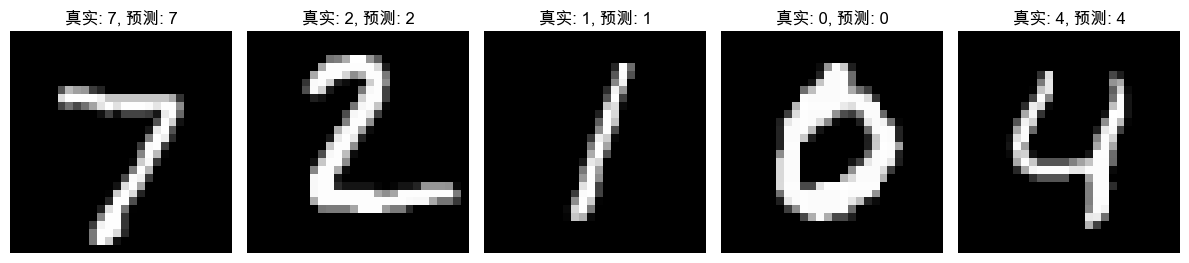

In [7]:
import matplotlib.pyplot as plt

# # 设置字体以支持中文
# # 以 Windows 为例，使用 'SimHei'
# plt.rcParams['font.sans-serif'] = ['PingFang SC']
# # 解决负号 '-' 显示为方块的问题
# plt.rcParams['axes.unicode_minus'] = False


# import matplotlib as mpl
# print(mpl.get_cachedir())
# print(mpl.matplotlib_fname())

# 加载测试图像并显示
def visualize_prediction(model, device, test_loader, num_samples=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        ax.set_title(f'真实: {labels[i].item()}, 预测: {predicted[i].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 可视化预测结果
visualize_prediction(model, device, test_loader)

MPS 可用，将使用 MPS 设备
模型加载成功！


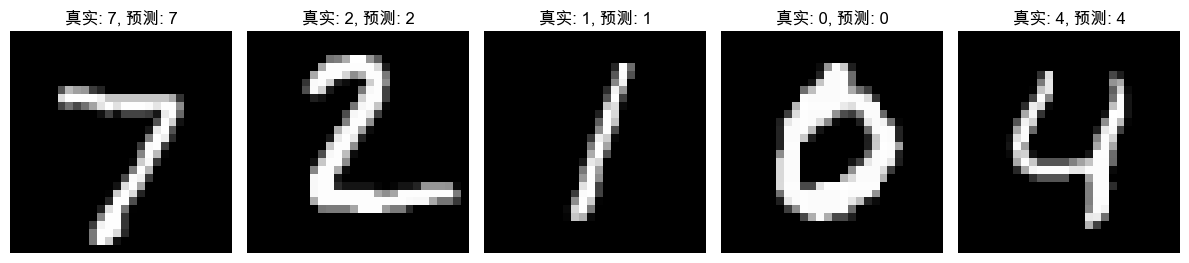

In [8]:
# `mnist_cnn_model.pth` 通常是 PyTorch 保存的模型文件，下面展示如何加载和使用这个文件。

import torch
from torchvision import datasets, transforms
import torch.nn as nn

# 定义与保存模型时相同的模型结构
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 第一层卷积: 1个输入通道, 32个输出通道,  kernel_size=3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # 第二层卷积: 32个输入通道, 64个输出通道, kernel_size=3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # 池化层: kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 全连接层: 7*7*64 -> 128
        self.fc1 = nn.Linear(7*7*64, 128)
        # 全连接层: 128 -> 10 (10个类别)
        self.fc2 = nn.Linear(128, 10)
        # Dropout层
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 第一层卷积 + ReLU + 池化
        x = self.pool(F.relu(self.conv1(x)))
        # 第二层卷积 + ReLU + 池化
        x = self.pool(F.relu(self.conv2(x)))
        # 展平
        x = x.view(-1, 7*7*64)
        # 全连接层 + ReLU + Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        # 输出层
        x = self.fc2(x)
        return x

# 检查 mps 是否可用
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS 可用，将使用 MPS 设备")
else:
    print("MPS 不可用，将使用默认设备")
    device = torch.device("cpu")

# 初始化模型并创建在指定设备中
model = SimpleCNN().to(device)

# 加载模型权重
try:
    # 直接使用 mps 加载模型权重
    model.load_state_dict(torch.load('model/mnist_cnn_model.pth', map_location=device))
    model.eval()  # 设置为评估模式
    print("模型加载成功！")
except FileNotFoundError:
    print("未找到 model/mnist_cnn_model.pth 文件，请检查文件路径。")
except Exception as e:
    print(f"加载模型时出错: {e}")

# 导入 MNIST 测试集
# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 加载测试集
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# # 获取一个测试样本
# data, _ = next(iter(test_loader))
# data = data.to(device)

# with torch.no_grad():
#     output = model(data)
#     predicted_class = torch.argmax(output, dim=1)
#     print(f"预测的类别是: {predicted_class.item()}")


# 加载测试图像并显示
def visualize_prediction(model, device, test_loader, num_samples=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        ax.set_title(f'真实: {labels[i].item()}, 预测: {predicted[i].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 可视化预测结果
visualize_prediction(model, device, test_loader)
